## Graphwalk Model

230513: Parse the model info and build a plot of the results  
230530: Load in the model weights and plot the hidden activations

Q's @ Keiland: kwcooper@uci.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
from torch import nn
from torchsummary import summary as model_summary


### Parse Model metadata

In [2]:
# Load in the model metadata
base_path = f'./'
m_path = f'{base_path}torchweights_v2/weights_meta.csv'
w_meta = pd.read_csv(m_path)
w_meta.head()

,I,task,L2,1,2,3,4,end_loss,mID,weight_name,path
0,0,I,6,44.811321,50.000000,45.454545,78.571429,0.0114,0,I_6_0.pt,/home/k/DATA/graphwalk/torchweights_v2/I_6_0.pt
1,1,I,6,55.760369,50.434783,61.290323,30.000000,0.0465,1,I_6_1.pt,/home/k/DATA/graphwalk/torchweights_v2/I_6_1.pt
2,2,I,6,47.008547,44.859813,29.787234,16.666667,0.0387,2,I_6_2.pt,/home/k/DATA/graphwalk/torchweights_v2/I_6_2.pt
3,3,I,6,58.750000,57.731959,74.545455,100.000000,0.0530,3,I_6_3.pt,/home/k/DATA/graphwalk/torchweights_v2/I_6_3.pt
4,4,I,6,51.082251,62.500000,44.897959,40.000000,0.0233,4,I_6_4.pt,/home/k/DATA/graphwalk/torchweights_v2/I_6_4.pt


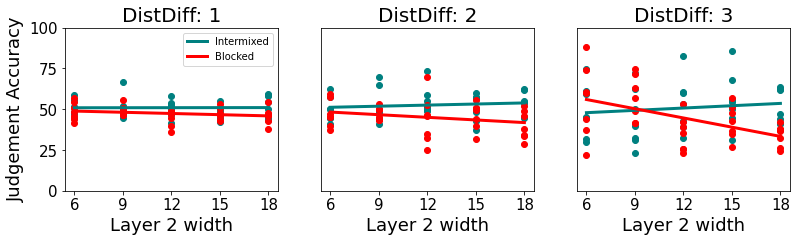

In [3]:

# Grab the two groups
w_i = w_meta[w_meta['task'] == 'I']
w_b = w_meta[w_meta['task'] == 'B']

dists_l = [1,2,3]
plt.figure(figsize=(13,3))
for i in dists_l:
    plt.subplot(1, len(dists_l), i)
    
    # Plot the accuracy scores
    acci = w_i[['L2', str(i)]].to_numpy()
    plt.scatter(acci[:,0], acci[:,1], color='teal')

    accb = w_b[['L2', str(i)]].to_numpy()
    plt.scatter(accb[:,0], accb[:,1], color='r')

    # find line of best fit
    ai, bi = np.polyfit(acci[:,0], acci[:,1], 1)
    ab, bb = np.polyfit(accb[:,0], accb[:,1], 1)
    plt.plot(acci[:,0], ai*acci[:,0]+bi, color='teal', linewidth=3, label='Intermixed')
    plt.plot(accb[:,0], ab*accb[:,0]+bb, color='r', linewidth=3, label='Blocked')
    
    # Make it look pretty now
    plt.title(f'DistDiff: {i}', size=20)

    if i == 1:
        plt.ylabel('Judgement Accuracy', size=18)
        plt.yticks([0, 25, 50, 75, 100], size=15)
        plt.legend()
    else:
        plt.yticks([])
        
    
    plt.xlabel(f'Layer 2 width', size=18)
    plt.ylim(0,100)
    plt.xticks([6, 9, 12, 15, 18], size=15)

### Parse model weights and representations

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cpu


In [5]:
# Crikey! Hey! Look! A deep neural network
class AE(nn.Module):
	
	def __init__(self, input_shape=100, L1=10, L2=5, n_hidden=3, 
				name='', weight_path=''):
		''' '''
		super(AE, self).__init__()
		self.name = name
		self.weight_path = weight_path
		self.input_shape = input_shape
		self.L1 = L1
		self.L2 = L2

		self.encoder = nn.Sequential(
			nn.Linear(input_shape, self.L1),
			nn.ReLU(True),
			nn.Linear(self.L1, self.L2),
			nn.ReLU(True), 
			nn.Linear(self.L2, n_hidden)
			)

		self.decoder = nn.Sequential(
			nn.Linear(n_hidden, self.L2),
			nn.ReLU(True),
			nn.Linear(self.L2, self.L1),
			nn.ReLU(True), 
			nn.Linear(self.L1, input_shape), 
			nn.Tanh()
			)

	def forward(self, x, encoding=False):
		''' '''
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		if encoding: # Return hidden later activations
			return encoded
		return decoded



In [6]:
# Some example code on how to work with the basic models
model = AE(input_shape=12, L1=12, L2=6).to(device)
model_summary(model, input_size=(1,12))

# Create a fake tensor
xx = torch.FloatTensor([1,1,1,1,1,1,1,1,1,1,1,1]).to(device)

# Send the tensor all the way through the model
model.forward(xx)

# Only grab the hidden activations for a model
model.forward(xx, encoding=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 12]             156
              ReLU-2                [-1, 1, 12]               0
            Linear-3                 [-1, 1, 6]              78
              ReLU-4                 [-1, 1, 6]               0
            Linear-5                 [-1, 1, 3]              21
            Linear-6                 [-1, 1, 6]              24
              ReLU-7                 [-1, 1, 6]               0
            Linear-8                [-1, 1, 12]              84
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 12]             156
             Tanh-11                [-1, 1, 12]               0
Total params: 519
Trainable params: 519
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

tensor([ 0.3718, -0.2716, -0.5944], grad_fn=<AddBackward0>)

In [7]:
# Iterate over model meta data, rebuilding models based on the saved weights
models = {}
for row_i, row in w_meta.iterrows():

    # Extract metadata for a model
    model_ID = row['mID']
    weight_name = row['weight_name']
    weight_path = f'{base_path}torchweights_v2/{weight_name}'
    L2 = row['L2']

    # Rebuild a base model
    basemodel = AE(input_shape=12, L1=12, L2=L2, name=model_ID).to(device)

    # Load in the weights and populate the model
    basemodel.load_state_dict(torch.load(weight_path, map_location=torch.device('cpu')))

    # Add model to dict
    models[int(model_ID)] = basemodel

print(f'Loaded {len(models)} models...')

Loaded 70 models...


In [8]:
# Define some helpful params
n_models = len(models)
input_shape = 12
n_hidden = 3
print(n_models, input_shape, n_hidden)

# Create a one-hot vector for each of the N items
item_data = np.eye(input_shape)
items = torch.FloatTensor(item_data).to(device)

70 12 3


In [17]:

# For all models, extract the hidden representations for the input data
all_hidden = np.empty((n_models, input_shape, n_hidden))
for ii in range(n_models):
    # This. Is. Where. The. Magic. Happens. 
    hidden_activation = models[ii].forward(items, encoding=True)
    all_hidden[ii, :, :] = hidden_activation.cpu().detach().numpy()
print(all_hidden.shape)


(70, 12, 3)


In [10]:
# Grab the model ID's for blocked and Interleaved training
I_models = w_meta[w_meta['task'] == 'I']['mID'].to_numpy()
B_models = w_meta[w_meta['task'] == 'B']['mID'].to_numpy()

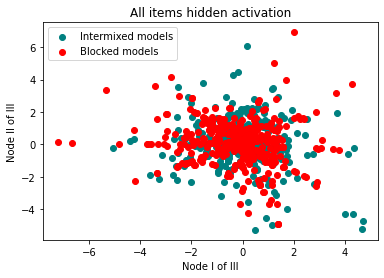

In [11]:
# Plot the first two hidden dim's
# Should be 3D but I'll leave that as a (pretty simple)
# excercise for the reader. Or do PCA etc on the 3D tensors? 
# SKY (and time) IS THE LIMIT

plt.scatter(all_hidden[I_models,:,0], all_hidden[I_models,:,1], 
            c='teal', label='Intermixed models')
plt.scatter(all_hidden[B_models,:,0], all_hidden[B_models,:,1], 
            c='r', label='Blocked models')

plt.title('All items hidden activation')
plt.xlabel('Node I of III')
plt.ylabel('Node II of III')
plt.legend()

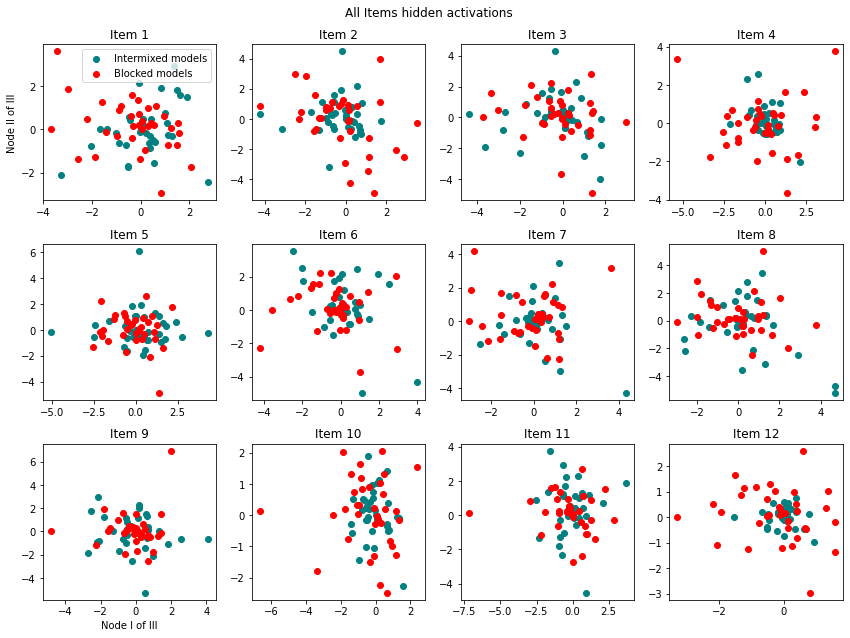

In [12]:

# Same as above but for each item
plt.figure(figsize=(12,9))
for item_i in range(input_shape):

    plt.subplot(3, 4, item_i+1)
    plt.scatter(all_hidden[I_models,item_i,0], all_hidden[I_models,item_i,1], 
                c='teal', label='Intermixed models')
    plt.scatter(all_hidden[B_models,item_i,0], all_hidden[B_models,item_i,1], 
                c='r', label='Blocked models')

    plt.title(f'Item {item_i+1}')
    
    if item_i == 8: plt.xlabel('Node I of III')
    if item_i == 0: plt.ylabel('Node II of III')
    if item_i ==0: plt.legend()

plt.suptitle('All Items hidden activations')
plt.tight_layout()

In [13]:
# Have fun! 

In [14]:
# Some code to examine the weights
weights = torch.load(weight_path, map_location=torch.device('cpu'))
for w_key in weights.keys():
    print(w_key, weights[w_key].shape)

encoder.0.weight torch.Size([12, 12])
encoder.0.bias torch.Size([12])
encoder.2.weight torch.Size([18, 12])
encoder.2.bias torch.Size([18])
encoder.4.weight torch.Size([3, 18])
encoder.4.bias torch.Size([3])
decoder.0.weight torch.Size([18, 3])
decoder.0.bias torch.Size([18])
decoder.2.weight torch.Size([12, 18])
decoder.2.bias torch.Size([12])
decoder.4.weight torch.Size([12, 12])
decoder.4.bias torch.Size([12])
